## Sentiment and Community Creation on Game of Thrones

We start by scraping the Game of thrones wiki for a dataset and load the kaggle dataset.

In [27]:
#import the libraries 
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
from bs4 import BeautifulSoup
import re
import requests

In [28]:
#scrape the data

#url of the page
baselink = "https://gameofthrones.fandom.com"
url = "https://gameofthrones.fandom.com/wiki/Category:Individuals_appearing_in_Game_of_Thrones"
url2 = "https://gameofthrones.fandom.com/wiki/Category:Individuals_appearing_in_Game_of_Thrones?from=Harker"
url3 = "https://gameofthrones.fandom.com/wiki/Category:Individuals_appearing_in_Game_of_Thrones?from=Red+priestess+%28High+Sparrow%29"

#make a get request to the page
page = requests.get(url)

#parse the html content
soup = BeautifulSoup(page.content, 'html.parser')

#find the table with the data
characterUrl = soup.find_all(class_='category-page__member-link')
characterHref = [i['href'] for i in characterUrl]
# Parse the additional pages
page2 = requests.get(url2)
soup2 = BeautifulSoup(page2.content, 'html.parser')
characterUrl2 = soup2.find_all(class_='category-page__member-link')
characterHref2 = [i['href'] for i in characterUrl2]

page3 = requests.get(url3)
soup3 = BeautifulSoup(page3.content, 'html.parser')
characterUrl3 = soup3.find_all(class_='category-page__member-link')
characterHref3 = [i['href'] for i in characterUrl3]

# Combine all character URLs
characterHref.extend(characterHref2)
characterHref.extend(characterHref3)

print(characterHref)

['/wiki/Aemon', '/wiki/Aggar', '/wiki/Aggo_(The_North_Remembers)', '/wiki/Aggo_(The_Red_Woman)', '/wiki/Alanna', '/wiki/Allo', '/wiki/Anara', '/wiki/Anguy', '/wiki/Archmaester_(Eastwatch)', '/wiki/Armeca', '/wiki/Jon_Arryn', '/wiki/Lysa_Arryn', '/wiki/Robin_Arryn', '/wiki/Arthur', '/wiki/Ash', '/wiki/Aya', '/wiki/Petyr_Baelish', '/wiki/Balerion', '/wiki/Balian', '/wiki/Bannen', '/wiki/Baratheon_general', '/wiki/Baratheon_soldier_(Mother%27s_Mercy)', '/wiki/Baratheon_soldier_(The_Dance_of_Dragons)', '/wiki/Edric_Baratheon', '/wiki/Gendry_Baratheon', '/wiki/Joffrey_Baratheon', '/wiki/Myrcella_Baratheon', '/wiki/Petyr_Baratheon', '/wiki/Renly_Baratheon', '/wiki/Robert_Baratheon', '/wiki/Selyse_Baratheon', '/wiki/Shireen_Baratheon', '/wiki/Stannis_Baratheon', '/wiki/Tommard_Baratheon', '/wiki/Tommen_Baratheon', '/wiki/Barra', '/wiki/Bastard%27s_girls', '/wiki/Bernadette', '/wiki/Bianca', '/wiki/Billy', '/wiki/Biter', '/wiki/Black_Lorren', '/wiki/Lord_Blackmont', '/wiki/Blood_(horse)', '/wi

In [30]:
#scraping function for the info box of the wiki
def get_character_data(characterHref):
    #get soup for the first character
    page = requests.get(baselink + characterHref)
    soup = BeautifulSoup(page.content, 'html.parser')

    # Locate the infobox, assuming it's in a div with class 'infobox' (you may need to adjust this)
    infobox = soup.find(class_='portable-infobox pi-background pi-border-color pi-theme-Westeros pi-theme-Watch pi-layout-default')
    # print(infobox)

    infobox_data = {}

    # Find all infobox data items
    for section in soup.find_all("div", class_="pi-item pi-data pi-item-spacing pi-border-color"):
        label = section.find("h3", class_="pi-data-label pi-secondary-font")
        value = section.find("div", class_="pi-data-value pi-font")

        if label and value:
            # Remove any references or citations from the value text
            for sup in value.find_all("sup"):
                sup.decompose()
            
            infobox_data[label.get_text(strip=True)] = value.get_text(" ", strip=True)

    return infobox_data

infobox_data = get_character_data(characterHref[0])

# Print the extracted information
for key, val in infobox_data.items():
    print(f"{key}: {val}")

Born: Aemon Targaryen 202 AC Red Keep , King's Landing
Died: 302 AC (aged 100) Castle Black , the Gift
House(s): Targaryen (renounced)
Affiliation(s): Order of Maesters Night's Watch
Title(s): Prince (formerly) Maester
Culture: Valyrian
Father: { Maekar I Targaryen }
Mother: { Dyanna Dayne }
Sibling(s): { Daeron Targaryen } { Aerion Targaryen } { Aegon V Targaryen }
Series: Game of Thrones
Season(s): 1 · 3 · 4 · 5
Appeared in: 11 episodes ( see below )
First seen in: " Lord Snow "
Last seen in: " The Gift "
Died in: "The Gift"
Portrayed by: Peter Vaughan


In [31]:
#get the data for all characters and store in pandas dataframe
data = []
for i in tqdm(characterHref):
    data.append(get_character_data(i))

df = pd.DataFrame(data)
df

100%|██████████| 594/594 [05:15<00:00,  1.88it/s]


,Born,Died,House(s),Affiliation(s),Title(s),Culture,Father,Mother,Sibling(s),Series,...,Portrayed by,Spouse(s),Religion,Issue,Also known as,Personal arms,Species,Affiliation,Lover(s),Family
0,"Aemon Targaryen 202 AC Red Keep , King's Landing","302 AC (aged 100) Castle Black , the Gift",Targaryen (renounced),Order of Maesters Night's Watch,Prince (formerly) Maester,Valyrian,{ Maekar I Targaryen },{ Dyanna Dayne },{ Daeron Targaryen } { Aerion Targaryen } { Ae...,Game of Thrones,...,Peter Vaughan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,"299 AC Winterfell , the North",NaN,House Greyjoy,NaN,Ironborn,NaN,NaN,NaN,Game of Thrones,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,{ Drogo } House Targaryen,Bloodrider,Dothraki,NaN,NaN,NaN,Game of Thrones,...,Niccolai McKinsky,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,"303 AC Vaes Dothrak , Dothraki Sea",NaN,{ Moro },NaN,Dothraki,NaN,NaN,NaN,Game of Thrones,...,Chuku Modu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,"305 AC King's Landing , the Crownlands",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Game of Thrones,...,Kim Chapman,Husband,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,Beyond the Wall,"301 AC Castle Black , the Wall",NaN,{ Mance Rayder },NaN,Free Folk,NaN,NaN,NaN,Game of Thrones,...,Rose Leslie,NaN,Old Gods,NaN,NaN,NaN,NaN,NaN,Jon Snow,NaN
590,NaN,"299 AC Near Harrenhal , the Riverlands",NaN,Night's Watch,NaN,Westerosi,NaN,NaN,{Brother},Game of Thrones,...,Francis Magee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
591,NaN,NaN,NaN,Wise Masters ( slave ),NaN,NaN,NaN,NaN,NaN,Game of Thrones,...,Talitha Luke-Eardley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
592,298 AC in Meereen,301 AC (aged 3) in Meereen Burned alive by Drogon,NaN,NaN,NaN,Ghiscari ( Meereenese ),Goatherd,NaN,NaN,Game of Thrones,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#add the character name to the dataframe with the character href
df['Name'] = [i.split('/')[-1].replace('_', ' ') for i in characterHref]
#let name be the first column
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df

,Name,Born,Died,House(s),Affiliation(s),Title(s),Culture,Father,Mother,Sibling(s),...,Portrayed by,Spouse(s),Religion,Issue,Also known as,Personal arms,Species,Affiliation,Lover(s),Family
0,Aemon,"Aemon Targaryen 202 AC Red Keep , King's Landing","302 AC (aged 100) Castle Black , the Gift",Targaryen (renounced),Order of Maesters Night's Watch,Prince (formerly) Maester,Valyrian,{ Maekar I Targaryen },{ Dyanna Dayne },{ Daeron Targaryen } { Aerion Targaryen } { Ae...,...,Peter Vaughan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Aggar,NaN,"299 AC Winterfell , the North",NaN,House Greyjoy,NaN,Ironborn,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aggo (The North Remembers),NaN,NaN,NaN,{ Drogo } House Targaryen,Bloodrider,Dothraki,NaN,NaN,NaN,...,Niccolai McKinsky,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Aggo (The Red Woman),NaN,"303 AC Vaes Dothrak , Dothraki Sea",NaN,{ Moro },NaN,Dothraki,NaN,NaN,NaN,...,Chuku Modu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alanna,NaN,"305 AC King's Landing , the Crownlands",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Kim Chapman,Husband,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,Ygritte,Beyond the Wall,"301 AC Castle Black , the Wall",NaN,{ Mance Rayder },NaN,Free Folk,NaN,NaN,NaN,...,Rose Leslie,NaN,Old Gods,NaN,NaN,NaN,NaN,NaN,Jon Snow,NaN
590,Yoren,NaN,"299 AC Near Harrenhal , the Riverlands",NaN,Night's Watch,NaN,Westerosi,NaN,NaN,{Brother},...,Francis Magee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
591,Yunkai%27i whore,NaN,NaN,NaN,Wise Masters ( slave ),NaN,NaN,NaN,NaN,NaN,...,Talitha Luke-Eardley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
592,Zalla,298 AC in Meereen,301 AC (aged 3) in Meereen Burned alive by Drogon,NaN,NaN,NaN,Ghiscari ( Meereenese ),Goatherd,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#After that we did some preprocessing on the afffiliation to get them from text to list of strings
def clean_affiliations_manual(data):
    cleaned_data = []
    for line in data:
        # Step 2: Remove {} but keep data inside, and remove ()
        line = re.sub(r'\{([^}]*)\}', r'\1', line)  # Keep text in {}
        line = re.sub(r'\([^)]*\)', '', line).strip()  # Remove text in ()
        #remove any double spaces
        #remove the word "House" and "House of" and "of King's Landing"
        line = re.sub(r'House of ', '', line)
        line = re.sub(r'House ', '', line)
        line = re.sub(r'of King\'s Landing', '', line)
        line = re.sub(r'of Dragonstone', '', line)
        line = re.sub(r'of Bran the Broken Small Council', '', line)
        line = re.sub(r'of Renly Baratheon', '', line)
        line = re.sub(r'\s+', ' ', line)
        #remove any leading and trailing spaces
        line = line.strip()

        #add cleaned data to the list
        cleaned_data.append(line)

    return cleaned_data

#clean the affiliations
affiliation = clean_affiliations_manual(df['Affiliation(s)'])
unique_affiliations = clean_affiliations_manual(unique_affiliations['Affiliation'])
# affiliation

In [ ]:
#add a comma after each affiliation based on the unique affiliations txt 
def add_comma(affiliation):
    #read the unique affiliations
    # unique_affiliations = pd.read_csv('data/unique_affiliations.csv')
    # unique_affiliations = unique_affiliations
    #add a comma after each affiliation based on the unique affiliations
    cleaned_affiliation = []
    for line in affiliation:
        for i in unique_affiliations:
            line = line.replace(i, i + ',')
        cleaned_affiliation.append(line)

    #if there is a comma at the end of the string, remove it
    #if there is two commas in a row, remove one
    #remove all spaces after commas
    cleaned_affiliation = [re.sub(r',\s+', ', ', i) for i in cleaned_affiliation]
    cleaned_affiliation = [re.sub(r',,', ',', i) for i in cleaned_affiliation]
    cleaned_affiliation = [i[:-1] if i.endswith(',') else i for i in cleaned_affiliation]

    

    return cleaned_affiliation

affiliation = add_comma(affiliation)

In [ ]:
#Add the cleaned affiliations to the dataframe
df['Affiliation(s)'] = affiliation
df['Dead'] = df['Died'].notnull().astype(int)
#save the data to a csv file
columns_to_keep = [
    "Name", "Born", "Died", "House(s)", "Affiliation(s)", "Title(s)", "Culture", 
    "Father", "Mother", "Sibling(s)", "Series", "Season(s)", "Appeared in", 
    "First seen in", "Last seen in", "Died in", "Portrayed by", "Spouse(s)", 
    "Religion", "Issue", "Also known as", "Personal arms", "Species", 
    "Affiliation", "Lover(s)", "Family", "Dead"
]

# Filter the DataFrame to keep only the specified columns
df = df[columns_to_keep]

df.to_csv('data/game_of_thrones_characters_cleaned.csv', index=False)
df

## Sentimental analysis

In [34]:
#load the scraped datasets
affiliations = pd.read_csv("data/Affiliation_mortality.csv")
characters = pd.read_csv("data/game_of_thrones_characters_cleaned.csv")

In [ ]:
#Overveiw of frequency of dead and alive character based on top affiliation.
affiliations.head()

,Affiliation(s),Alive,Dead,Total
0,Unknown,75,83,158
1,Night's Watch,31,40,71
2,Stark,36,39,75
3,Baratheon,17,30,47
4,Targaryen,15,26,41


In [12]:
dialogues_df = pd.read_csv("data/dialouges_over_time.csv")
characters_df = pd.read_csv("data/characters_w_map.csv")
end_sentiment_df = pd.read_csv("data/end_sentiment.csv")
affiliations_df = pd.read_csv("data/Affiliation_mortality.csv")


# remove ''Roose Bolton%27s son'' from character df
characters_df = characters_df[characters_df['Name'] != "Roose Bolton%27s son"]

# Dictionary for mapping specific house values
# Dictionary for mapping specific house values
house_mapping = {
    'Tully Arryn (by marriage) Baelish (by marriage)': 'Arryn',
    'Bolton ( legitimized )': 'Bolton',
    "Lannister Baratheon of King's Landing (by marriage)": 'Lannister',
    'Tully Stark (by marriage)': 'Stark',
    'Stark Lannister (by marriage) Bolton (by marriage)': 'Stark',
    'Tyrell Baratheon (by marriage) Baratheon of King\'s Landing (by marriage)': 'Tyrell',
    'Baratheon ( legitimized )': 'Baratheon',
    'Baratheon of King\'s Landing Lannister': 'Baratheon',
    "Baratheon Baratheon of King's Landing": 'Baratheon',
    'Baratheon of King\'s Landing': 'Baratheon',
    'Redwyne Tyrell (by marriage)': 'Tyrell',

}

# Fix the DataFrame by converting string representations of lists into actual lists of strings
import ast

def fix_affiliations(entry):
    """
    Converts a string representation of a list into an actual list of strings.
    """
    if isinstance(entry, str):
        try:
            # Safely evaluate the string as a Python literal
            return ast.literal_eval(entry)
        except (ValueError, SyntaxError):
            return []  # Return an empty list if the conversion fails
    return entry  # Return the entry unchanged if it's already a list

# Apply the fix to the 'Affiliation(s)' column
characters_df['Affiliation(s)'] = characters_df['Affiliation(s)'].apply(fix_affiliations)


def process_character_affiliations(character_df):
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    character_df = character_df.copy()

    
    # Define a helper function to process each row
    def combine_affiliations(row):
        affiliations = row['Affiliation(s)'] if isinstance(row['Affiliation(s)'], list) else []
        house = row['House(s)']
        
        # Map house value if it's in the dictionary
        if house in house_mapping:
            house = house_mapping[house]
        
        # Combine affiliations and house into a single list
        combined_list = affiliations + [house]

        # 'remove' 'unknown' from affiliations if there is atleast one more affiliation
        if 'Unknown' in combined_list:
            combined_list = [aff for aff in combined_list if aff != 'Unknown']

        # 'remove' 'nan' from affiliations if there is at least one more affiliation
        if any(math.isnan(aff) if isinstance(aff, float) else False for aff in combined_list):
            # Remove nan
            combined_list = [aff for aff in combined_list if not (isinstance(aff, float) and math.isnan(aff))]

        if row['Name'] == 'Margaery Tyrell':
            combined_list.append('Baratheon')

        return combined_list
    
    # Use .loc to set values in the dataframe
    character_df.loc[:, 'affiliations'] = character_df.apply(combine_affiliations, axis=1)
    
    return character_df

def map_sentiments_to_characters(characters_df, end_sentiment_df):
    """
    Maps sentiment values from end_sentiment_df to characters_df.

    Parameters:
        characters_df (pd.DataFrame): DataFrame containing character data, including a 'mapped' column.
        end_sentiment_df (pd.DataFrame): DataFrame containing sentiment data with 'speaker' and sentiment columns.

    Returns:
        pd.DataFrame: Updated characters_df with two new columns:
                      'final_accumulative_sentiment' and 'final_average_sentiment'.
    """
    # Initialize new columns with default value 0
    characters_df['final_accumulative_sentiment'] = 0
    characters_df['final_average_sentiment'] = 0

    # Create a dictionary mapping speakers to sentiment values for efficient lookup
    sentiment_mapping = end_sentiment_df.set_index('speaker')[['final_accumulative_sentiment', 'final_average_sentiment']].to_dict('index')

    # Map sentiments to characters
    def map_sentiments(row):
        character = row['mapped']
        if character in sentiment_mapping:
            return sentiment_mapping[character]['final_accumulative_sentiment'], sentiment_mapping[character]['final_average_sentiment']
        else:
            return 0, 0  # Default value if character is not in sentiment_mapping

    # Apply the mapping
    characters_df[['final_accumulative_sentiment', 'final_average_sentiment']] = characters_df.apply(
        lambda row: pd.Series(map_sentiments(row)),
        axis=1
    )

    return characters_df

characters_df = process_character_affiliations(characters_df)
characters_df = map_sentiments_to_characters(characters_df, end_sentiment_df)

In [42]:
# Count the number of lines for each character
line_counts = dialogues_df['mapped'].value_counts()

# Get the top 20 characters with the most lines
top_100_characters = line_counts.head(100).reset_index()

# Rename columns for clarity
top_100_characters.columns = ['character', 'line_count']

characters_top = characters_df.loc[characters_df['mapped'].isin(top_100_characters['character'])]
end_sentiment_top = end_sentiment_df.loc[end_sentiment_df['speaker'].isin(top_100_characters['character'])]
dialogues_top = dialogues_df.loc[dialogues_df['mapped'].isin(top_100_characters['character'])]

In [43]:
end_sentiment_top

,speaker,final_accumulative_sentiment,final_average_sentiment
7,myrcella baratheon,-2.710390,-1.000000
10,benjen stark,6.174735,0.076923
18,loras tyrell,-0.327591,0.000000
20,jory cassel,23.661505,0.161290
21,bran stark,-30.466268,-0.190476
...,...,...,...
277,gendry,-113.511026,-0.242424
278,grey worm,-60.412143,-0.228070
279,davos,41.694621,-0.005941
281,brienne,-122.387626,-0.158730


In [44]:
# normalise final_accumulative_sentiment and final_average_sentiment to range -1 to 1
scaler_acc = MinMaxScaler(feature_range=(-1, 1))
scaler_avg = MinMaxScaler(feature_range=(-1, 1))

# Create copies of the columns to transform
acc_values = characters_top[['final_accumulative_sentiment']].copy()
avg_values = characters_top[['final_average_sentiment']].copy()

# Fit and transform the values
characters_top.loc[:,'final_accumulative_sentiment'] = scaler_acc.fit_transform(acc_values)
characters_top.loc[:,'final_average_sentiment'] = scaler_avg.fit_transform(avg_values)

In [45]:
characters_top

,Name,Born,Died,House(s),Affiliation(s),Title(s),Culture,Father,Mother,Sibling(s),...,Personal arms,Species,Affiliation,Lover(s),Family,Dead,mapped,affiliations,final_accumulative_sentiment,final_average_sentiment
1,Anguy,"Dornish Marches , the Stormlands",NaN,NaN,[Brotherhood Without Banners],NaN,Marcher,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0,anguy,[Brotherhood Without Banners],-0.323275,-0.133333
2,Lysa Arryn,"Lysa Tully Riverrun , the Riverlands","301 AC The Eyrie , the Vale of Arryn",Tully Arryn (by marriage) Baelish (by marriage),[Unknown],NaN,Rivermen,{ Hoster Tully },{ Minisa Whent },NaN,...,NaN,NaN,NaN,NaN,NaN,1,lysa arryn,[Arryn],-0.211707,0.096774
3,Robin Arryn,"289 AC (age 16) Red Keep , King's Landing",NaN,Arryn,[Royce],Lord of the Eyrie Defender of the Vale Warden ...,Valemen,{ Jon Arryn },{ Lysa Tully },NaN,...,NaN,NaN,NaN,NaN,NaN,0,robin arryn,"[Royce, Arryn]",-0.365178,-0.400000
5,Petyr Baelish,"The Fingers , the Vale of Arryn","304 AC Winterfell , the North",Baelish,"[Tully, Arryn, Baratheon, Stark]",Master of Coin (formerly) Lord of Harrenhal Lo...,Valemen,{ Lord Baelish },NaN,NaN,...,"Yellow, a black mockingbird",NaN,NaN,NaN,NaN,1,petyr baelish,"[Tully, Arryn, Baratheon, Stark, Baelish]",-0.025477,0.107143
6,Gendry Baratheon,"Gendry Flea Bottom , King's Landing",NaN,Baratheon ( legitimized ),"[Tobho Mott, Targaryen]",Lord of Storm's End Lord Paramount of the Stor...,Crownlander,{ Robert I Baratheon },NaN,NaN,...,NaN,NaN,NaN,Arya Stark,NaN,0,gendry,"[Tobho Mott, Targaryen, Baratheon]",-0.949909,-0.242424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,Olenna Tyrell,"Olenna Redwyne The Arbor , the Reach","304 AC Highgarden , the Reach",Redwyne Tyrell (by marriage),[Targaryen],NaN,Reach,NaN,NaN,Viola Redwyne,...,NaN,NaN,NaN,NaN,NaN,1,olenna,"[Targaryen, Tyrell]",-0.719924,-0.151515
287,Varys,Lys,"305 AC Dragonstone , the Crownlands",NaN,"[Targaryen, Baratheon, Small Council]",Master of Whisperers,Lysene,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,varys,"[Targaryen, Baratheon, Small Council]",-0.414132,-0.051546
289,Waif,NaN,303 AC in Braavos Killed by Arya Stark with Ne...,NaN,[Faceless Men],NaN,Braavosi,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,waif,[Faceless Men],-0.761803,-0.480000
301,Ygritte,Beyond the Wall,"301 AC Castle Black , the Wall",NaN,[Mance Rayder],NaN,Free Folk,NaN,NaN,NaN,...,NaN,NaN,NaN,Jon Snow,NaN,1,ygritte,[Mance Rayder],-0.898509,-0.251462


## Community Creation

In [40]:
# Initialize the graph
G = nx.Graph()

# Add nodes for all characters
for _, row in characters_top.iterrows():
    character = row['Name']
    G.add_node(character)  # Add the character as a node

# Add edges based on shared affiliations
for i, row_i in characters_top.iterrows():
    char_i = row_i['Name']
    affiliations_i = set(row_i['affiliations'])
    
    for j, row_j in characters_top.iterrows():
        if i >= j:  # Avoid duplicate pairs or self-loops
            continue
        char_j = row_j['Name']
        affiliations_j = set(row_j['affiliations'])
        
        # Check for shared affiliations
        if affiliations_i & affiliations_j:  # Non-empty intersection
            G.add_edge(char_i, char_j)

# Add node attributes
for _, row in characters_top.iterrows():
    character = row['Name']
    house = row.get('House(s)', 'Unknown')  # Default to 'Unknown' if column is missing
    # Map house value if it's in the dictionary
    if house in house_mapping:
        house = house_mapping[house]
    died = row.get('Died', 'Unknown')      # Default to 'Unknown' if column is missing
    culture = row.get('Culture', 'Unknown')
    final_accumulative_sentiment = row.get('final_accumulative_sentiment', 0)
    final_average_sentiment = row.get('final_average_sentiment', 0)
    # Add attributes
    G.nodes[character]['House'] = house
    G.nodes[character]['Died'] = died
    G.nodes[character]['Culture'] = culture
    G.nodes[character]['final_accumulative_sentiment'] = final_accumulative_sentiment
    G.nodes[character]['final_average_sentiment'] = final_average_sentiment

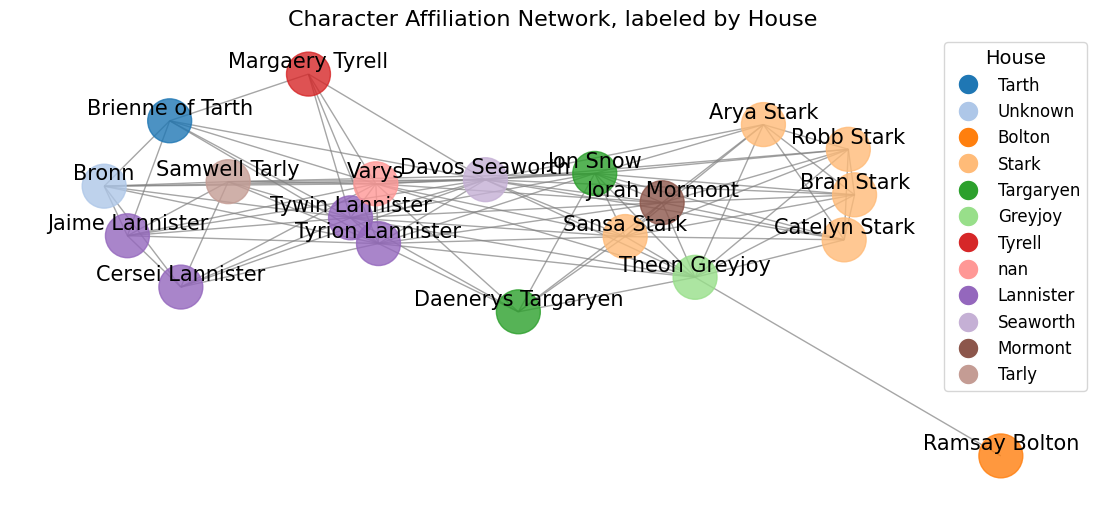

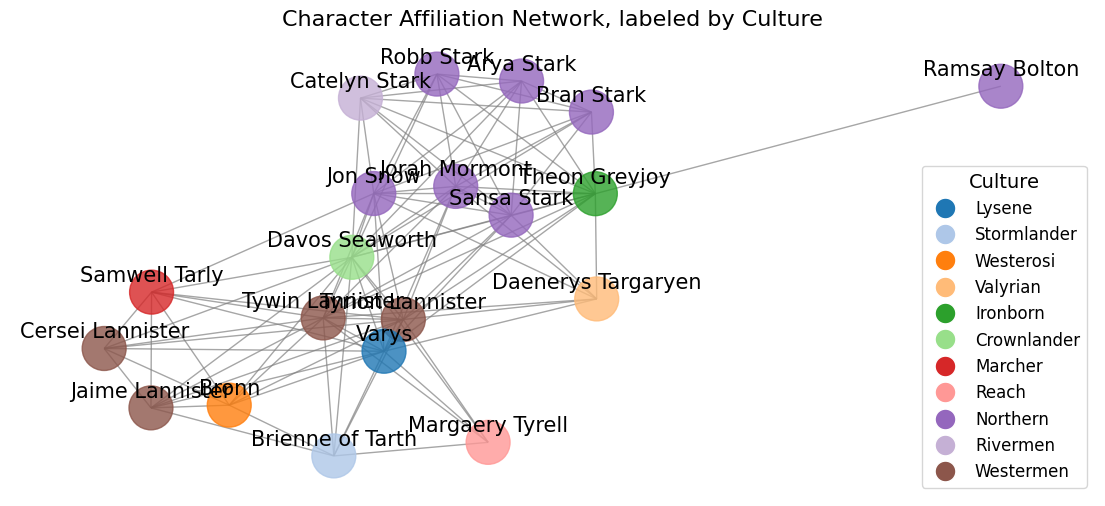

In [41]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

def draw_graph(G, node_color_attribute = 'House'):
    # Create a subgraph with only nodes that have at least one edge
    nodes_with_edges = [node for node in G.nodes() if G.degree(node) > 0]
    subgraph = G.subgraph(nodes_with_edges)

    # Create a color map for houses
    node_attribute = set(nx.get_node_attributes(subgraph, node_color_attribute).values())  # Get unique houses
    colors = plt.cm.tab20.colors  # Use a colormap with distinct colors
    node_attribute_color_map = {node_attribute: colors[i % len(colors)] for i, node_attribute in enumerate(node_attribute)}

    # Assign colors to nodes based on their house
    node_colors = [node_attribute_color_map[subgraph.nodes[node].get(node_color_attribute, 'Unknown')] for node in subgraph.nodes]

    # Draw the graph
    plt.figure(figsize=(14, 6))

    # Position nodes using a layout
    pos = nx.spring_layout(subgraph)

    # Draw nodes with assigned colors
    nx.draw_networkx_nodes(subgraph, pos, node_size=1000, node_color=node_colors, alpha=0.8)

    # Draw edges, filtering out edges with nan affiliations
    edges = [(u, v) for (u, v) in subgraph.edges() if not (math.isnan(subgraph.nodes[u].get('affiliations', 0)) or math.isnan(subgraph.nodes[v].get('affiliations', 0)))]
    nx.draw_networkx_edges(subgraph, pos, edgelist=edges, edge_color="gray", alpha=0.7)

    # Draw labels (names above nodes)
    offset_pos = {key: (x, y + 0.05) for key, (x, y) in pos.items()}  # Adjust position upwards
    nx.draw_networkx_labels(subgraph, offset_pos, font_size=15, font_color="black")

    # Create a legend for the houses
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15, label=house)
                    for house, color in node_attribute_color_map.items()]
    plt.legend(handles=legend_handles, loc='best', title=node_color_attribute, fontsize=12, title_fontsize=14)

    # Add title and turn off axis
    plt.title(f"Character Affiliation Network, labeled by {node_color_attribute}", fontsize=16)
    plt.axis("off")
    plt.show()

draw_graph(G, node_color_attribute='House')
draw_graph(G, node_color_attribute='Culture')


In [20]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

# Detect communities in the graph using Louvain's method
partition = community_louvain.best_partition(G)

# Add the community as a node attribute
nx.set_node_attributes(G, partition, 'community')

# Print communities
for node, community_id in partition.items():
    print(f"{node} belongs to community {community_id}")

Anguy belongs to community 7
Lysa Arryn belongs to community 1
Robin Arryn belongs to community 1
Petyr Baelish belongs to community 1
Gendry Baratheon belongs to community 3
Joffrey Baratheon belongs to community 7
Myrcella Baratheon belongs to community 7
Renly Baratheon belongs to community 7
Robert Baratheon belongs to community 3
Selyse Baratheon belongs to community 4
Shireen Baratheon belongs to community 5
Tommen Baratheon belongs to community 7
Ramsay Bolton belongs to community 9
Roose Bolton belongs to community 1
Bronn belongs to community 7
Jory Cassel belongs to community 1
Lady Crane belongs to community 8
Craster belongs to community 9
Xaro Xhoan Daxos belongs to community 10
Beric Dondarrion belongs to community 7
Doreah belongs to community 3
Walder Frey belongs to community 7
Gilly belongs to community 11
Grenn belongs to community 9
Grey Worm belongs to community 3
Euron Greyjoy belongs to community 7
Theon Greyjoy belongs to community 1
Yara Greyjoy belongs to comm

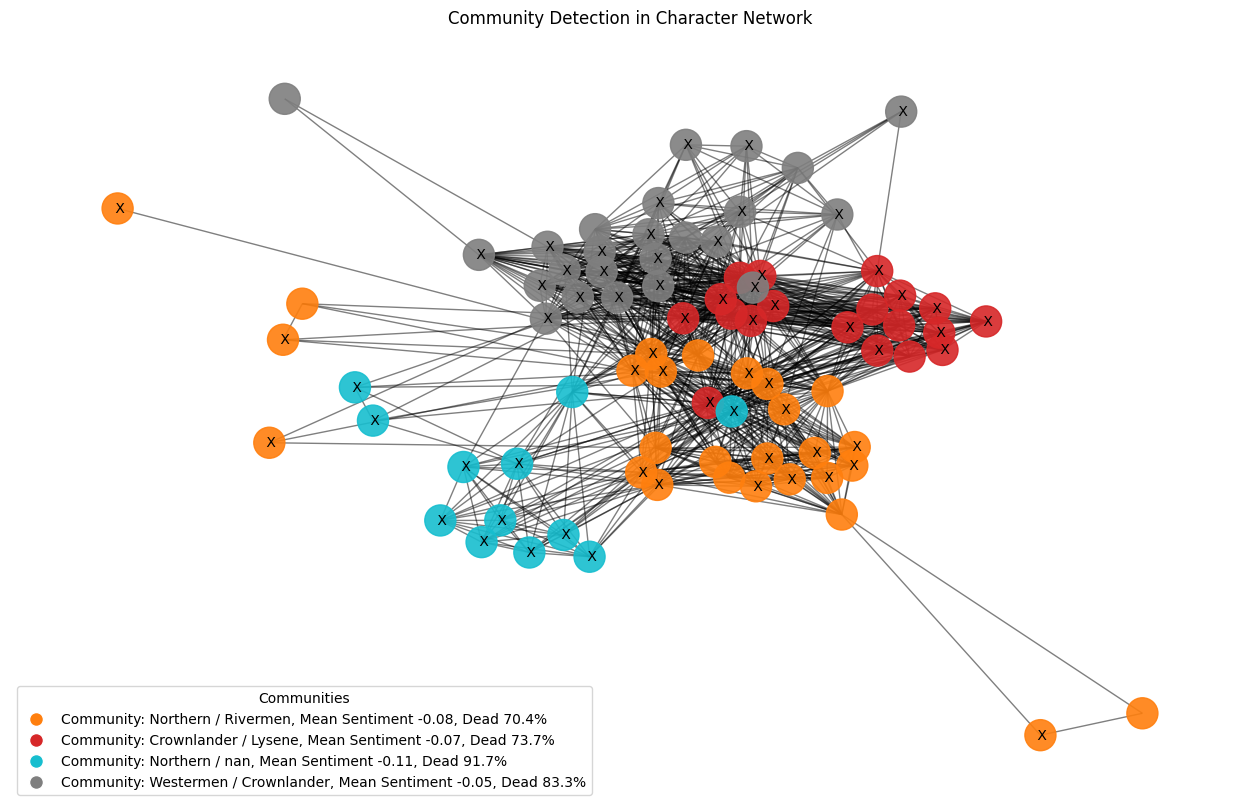

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Calculate community sizes
community_sizes = Counter(partition.values())

# Filter communities with more than 5 members
filtered_communities = {comm for comm, size in community_sizes.items() if size > 5}

# Filter nodes with 2 or more edges
nodes_with_edges = [node for node in G.nodes if G.degree[node] >= 2]
filtered_communities = {comm for comm in filtered_communities 
                      if any(partition[node] == comm for node in nodes_with_edges)}

# Generate unique community names based on the top two cultures
community_cultures = {}
used_names = set()

for comm in filtered_communities:
    community_nodes = [node for node in G.nodes if partition[node] == comm and node in nodes_with_edges]
    cultures = [G.nodes[node].get('Culture', 'Unknown') for node in community_nodes]
    most_common_cultures = [culture for culture, _ in Counter(cultures).most_common()]
    
    # Try creating unique community names
    name = f"{most_common_cultures[0]} / {most_common_cultures[1]}"  # First two cultures
    if name in used_names and len(most_common_cultures) > 2:
        # Use the first and third if the name is already taken
        name = f"{most_common_cultures[0]} / {most_common_cultures[2]}"
    elif name in used_names and len(most_common_cultures) > 3:
        # Use the first and fourth if needed
        name = f"{most_common_cultures[0]} / {most_common_cultures[3]}"
    
    # Store the name and mark it as used
    community_cultures[comm] = name
    used_names.add(name)

# Calculate mean sentiment and dead percentage for each community
community_data = {}
for comm in filtered_communities:
    community_nodes = [node for node in G.nodes if partition[node] == comm and node in nodes_with_edges]
    
    # Mean sentiment
    mean_sentiment = np.mean([
        G.nodes[node]['final_average_sentiment'] for node in community_nodes
    ])
    
    # Dead percentage
    total_nodes = len(community_nodes)
    dead_nodes = sum(
        1 for node in community_nodes if G.nodes[node].get('Died') and isinstance(G.nodes[node]['Died'], str)
    )
    dead_percentage = (dead_nodes / total_nodes) * 100
    
    community_data[comm] = {
        "mean_sentiment": mean_sentiment,
        "dead_percentage": dead_percentage
    }

# Create legend labels using the unique culture-based names, mean sentiment, and dead percentage
legend_labels = {
    comm: f"Community: {community_cultures[comm]}, Mean Sentiment {data['mean_sentiment']:.2f}, Dead {data['dead_percentage']:.1f}%"
    for comm, data in community_data.items()
}

# Generate a colormap for the communities
cmap = plt.cm.tab10
community_color_map = {comm: cmap(comm % cmap.N) for comm in filtered_communities}

# Draw the graph
plt.figure(figsize=(16, 10))
pos = nx.spring_layout(G)

# Draw nodes only for filtered communities and nodes with 2+ edges, with correct colors
for comm in filtered_communities:
    community_nodes = [node for node in G.nodes if partition[node] == comm and node in nodes_with_edges]
    nx.draw_networkx_nodes(
        G, pos, nodelist=community_nodes, node_size=500,
        node_color=[community_color_map[comm]] * len(community_nodes), alpha=0.9
    )

# Draw edges only for filtered communities and nodes with 2+ edges
filtered_edges = [
    (u, v) for u, v in G.edges 
    if partition[u] in filtered_communities and partition[v] in filtered_communities
    and u in nodes_with_edges and v in nodes_with_edges
]
nx.draw_networkx_edges(G, pos, edgelist=filtered_edges, alpha=0.5)

# Update labels: Add X for dead characters
updated_labels = {}
for node in nodes_with_edges:
    name = node
    if G.nodes[node].get('Died') and isinstance(G.nodes[node]['Died'], str):
        name = " X"  # Add X for dead characters
    else:
        name = ''
    updated_labels[node] = name

# Draw updated labels
nx.draw_networkx_labels(G, pos, labels=updated_labels, font_size=10, font_color="black")

# Add legend
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=community_color_map[comm], 
               markersize=10, label=label)
    for comm, label in legend_labels.items()
]
plt.legend(handles=legend_handles, loc='best', title="Communities")

plt.title("Community Detection in Character Network")
plt.axis("off")
plt.show()


In [22]:
# Create a list to store data for the DataFrame
data = []

# Iterate through nodes and filter only those in filtered communities
for node in G.nodes:
    community_id = partition[node]
    if community_id in filtered_communities:
        # Get node attributes
        attributes = G.nodes[node]
        
        # Add community name to attributes
        attributes['Name'] = node
        attributes['Community'] = community_cultures[community_id]
        
        # Append to data list
        data.append(attributes)

# Create DataFrame
df_comms = pd.DataFrame(data)

# add is_dead column, a character is dead if 'Died' is not nan
df_comms['is_dead'] = df_comms['Died'].notna()

# Get unique communities
communities = df_comms['Community'].unique()

In [23]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

def plot_community_bars_with_support(df_comms, mean_support, sentiment_column='final_accumulative_sentiment'):

    # Get unique communities
    communities = df_comms['Community'].unique()

    for community_name in communities:
        # Create a copy of the filtered data to avoid SettingWithCopyWarning
        community_df = df_comms[df_comms['Community'] == community_name].copy()

        # Normalize the final_average_sentiment to range 0 to 1
        scaler = MinMaxScaler(feature_range=(0, 1))
        community_df.loc[:, sentiment_column] = scaler.fit_transform(
            community_df[[sentiment_column]]
        )

        # Sort the data by sentiment value and create bar plot
        sorted_data = community_df.sort_values(sentiment_column)
        plt.figure(figsize=(8, 3))

        # Create bar plot with colors based on is_dead column
        colors = ['#8B4343' if dead else '#4B6B8C' for dead in sorted_data['is_dead']]  # Muted red and blue tones
        plt.bar(range(len(sorted_data)), sorted_data[sentiment_column], color=colors)

        # Calculate average and mean support bounds
        avg_sentiment = sorted_data[sentiment_column].mean()
        upper_bound = avg_sentiment + mean_support
        lower_bound = avg_sentiment - mean_support

        # if a character is not dead, and the average sentiment is above the upper bound, print the name of the character
        for index, row in sorted_data.iterrows():
            if not row['is_dead']:
                print(row['Name'])

        # Add average line (solid)
        plt.axhline(y=avg_sentiment, color='black', linestyle='-', label=f'Average ({avg_sentiment:.2f})')

        # Add mean support lines (dashed)
        plt.axhline(y=upper_bound, color='gray', linestyle='--', label=f'Upper Bound ({upper_bound:.2f})')
        plt.axhline(y=lower_bound, color='gray', linestyle='--', label=f'Lower Bound ({lower_bound:.2f})')

        # Add gray shaded box between dashed lines
        plt.fill_between(
            range(len(sorted_data)), lower_bound, upper_bound,
            color='gray', alpha=0.2, label='Mean Support Range'
        )

        # Add legend and labels
        plt.legend()
        plt.title(f"{community_name} Community")
        plt.ylabel('Normalized Average Sentiment')
        plt.xticks([])  # Hide x-axis labels
        plt.show()


Brienne of Tarth
Anguy
Bronn
Podrick Payne


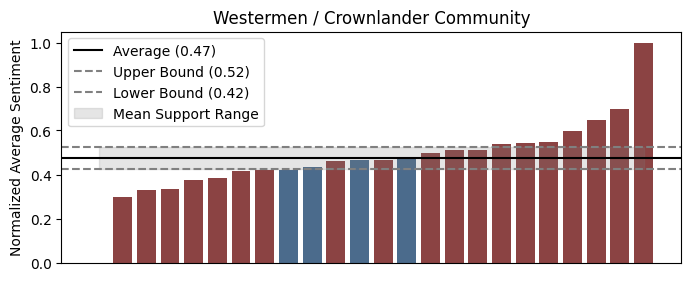

Robin Arryn
Arya Stark
Sansa Stark
Bran Stark
Meera Reed
Jaqen H%27ghar
Edmure Tully
Davos Seaworth
Olyvar


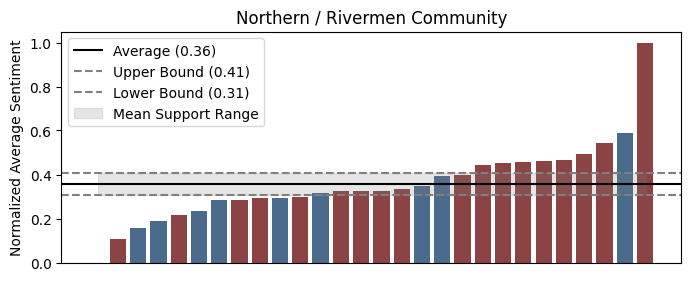

Daario Naharis
Gendry Baratheon
Grey Worm
Tyrion Lannister
Yara Greyjoy


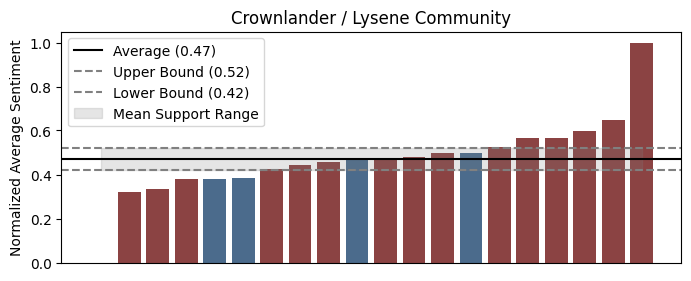

Samwell Tarly


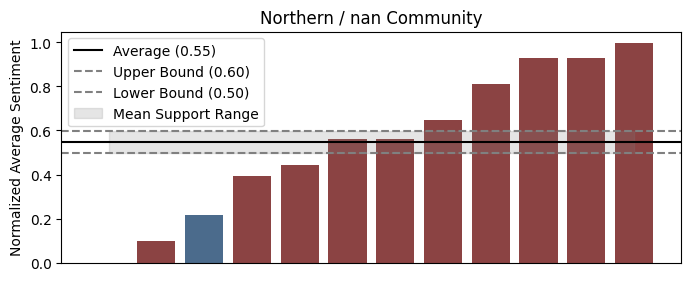

In [24]:
plot_community_bars_with_support(df_comms, mean_support=0.05, sentiment_column='final_average_sentiment')